## Семинар 7: "Методы оптимизации"

ФИО:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.autograd import Variable
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [3]:
class Optimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    def zero_grad(self):
        for param in self.parameters:      
            param.grad.zero_()
  
    def step(self, F):
        loss = F()
        loss.backward()        

        
class SGD(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for param in self.parameters:
                param -= self.learning_rate * param.grad
                
class Momentum(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.v = [torch.zeros_like(param) for param in self.parameters]
        
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                param -= v
                
class NAG(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.v = [torch.zeros_like(param) for param in self.parameters]
        
        self.gamma = gamma
    
    def step(self, F):
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param -= v
        
        super().step(F)
        
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param += v
                
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                
                param -= v
                
class RMSProp(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate * 10
        
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-9
        
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad

In [18]:
x_0 = np.array([2.5, 1.5]).reshape(1, -1)

def F(x):
    # return (x**2).sum(-1)
    
    x, y = x[:, 0], x[:, 1]
    
    return torch.sin(x) * x**2 * y + torch.cos(y**2) * y**2

optimizers = [SGD, Momentum, NAG, RMSProp]
colors = ["red", "blue", "yellow", "pink"]

optim_path = []

for optim in optimizers:
    # print(optim.__name__)
    
    x = torch.tensor(x_0, requires_grad=True)
    optim = optim([x], learning_rate=0.01)
    
    points = []
    
    for i in range(20):
        p_z = F(x).item()
        #print(p_z)
        
        p_x, p_y = x.detach().numpy().flatten()        
        # print(p_z, p_x, p_y)
        points.append((p_x, p_y, p_z))

        optim.step(lambda: F(x))
        optim.zero_grad()
        
    optim_path.append(points)

In [16]:
R = 2
N = 21

space = np.linspace(R, -R, N)
X, Y = np.meshgrid(space, space)

Z = F(torch.tensor([X.flatten(), Y.flatten()]).T).reshape(N, N)

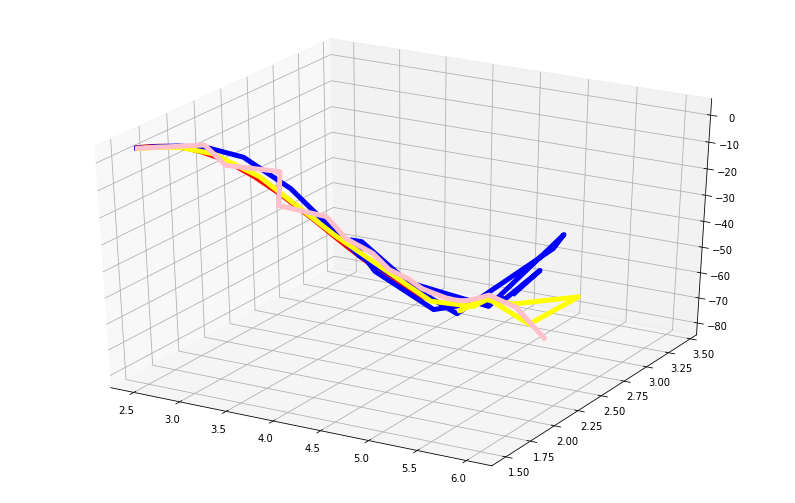

In [20]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot a basic wireframe.
# ax.plot_wireframe(space, space, Z)

for color, path in zip(colors, optim_path):
    points = np.array(path)
    #print(points)
    points += np.random.rand(3) * 0.04
    ax.plot(points[:, 0], points[:, 1], points[:, 2], color=color, linewidth=5)

"""
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
"""

#ax.view_init(30, 45)
plt.show()

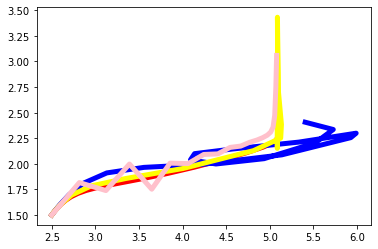

In [ ]:
for color, path in zip(colors, optim_path):
    points = np.array(path)        
    plt.plot(points[:, 0], points[:, 1], color=color, linewidth=5)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [ ]:
f = lambda X: X[0]**2+X[1]**2
df = lambda X: np.array([2*X[0], 2*X[1]])



<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i>

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

In [ ]:
transform = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: